In [5]:
from pydrake.solvers import MathematicalProgram
import numpy as np
import matplotlib.pyplot as plt

prog = MathematicalProgram()

x=prog.NewContinuousVariables(2)

print(x)
print(1 + 2*x[0] + 3*x[1] + 4*x[1])


[Variable('x(0)', Continuous) Variable('x(1)', Continuous)]
(1 + 2 * x(0) + 7 * x(1))


In [6]:
y = prog.NewContinuousVariables(2, "dog")
print(y)
print(y[0] + y[0] + y[1] * y[1] * y[1])

[Variable('dog(0)', Continuous) Variable('dog(1)', Continuous)]
(2 * dog(0) + pow(dog(1), 3))


In [8]:
var_matrix=prog.NewContinuousVariables(3,2,"A")

In [9]:
# Add the constraint x(0) * x(1) = 1 to prog
prog.AddConstraint(x[0] * x[1] == 1)

In [10]:
prog.AddConstraint(x[0] >= 0)
prog.AddConstraint(x[0] - x[1] <= 0)

In [11]:
# Add a cost x(0)**2 + 3 to the total cost. Since prog doesn't have a cost before, now the total cost is x(0)**2 + 3
prog.AddCost(x[0] ** 2 + 3)

In [12]:
prog.AddCost(x[0] + x[1])

In [13]:
from IPython.display import display, Markdown
display(Markdown(prog.ToLatex()))

\begin{align*}
\min_{x_{0}, x_{1}, dog_{0}, dog_{1}, A_{0,0}, A_{1,0}, A_{2,0}, A_{0,1}, A_{1,1}, A_{2,1}} \quad & (x_{0} + x_{1})\\
 &  + (3 + x_{0}^{2})\\
 \text{subject to}\quad & \begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix}^T \begin{bmatrix} 0 & 0.500 \\ 0.500 & 0 \end{bmatrix} \begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix} = 1,\\
 & (x_{0} - x_{1}) \le 0,\\
 & -0 \le x_{0}.\\
\end{align*}


In [14]:
"""
Solves a simple optimization problem
       min x(0)^2 + x(1)^2
subject to x(0) + x(1) = 1
           x(0) <= x(1)
"""
from pydrake.solvers import Solve
# Set up the optimization problem.
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] + x[1] == 1)
prog.AddConstraint(x[0] <= x[1])
prog.AddCost(x[0] **2 + x[1] ** 2)

# Now solve the optimization problem.
result = Solve(prog)

# print out the result.
print("Success? ", result.is_success())
# Print the solution to the decision variables.
print('x* = ', result.GetSolution(x))
# Print the optimal cost.
print('optimal cost = ', result.get_optimal_cost())
# Print the name of the solver that was called.
print('solver is: ', result.get_solver_id().name())

Success?  True
x* =  [0.4999745 0.5000255]
optimal cost =  0.5000000013010027
solver is:  Clarabel


In [15]:
"""
An infeasible optimization problem.
"""
prog = MathematicalProgram()
x = prog.NewContinuousVariables(1)[0]
y = prog.NewContinuousVariables(1)[0]
prog.AddConstraint(x + y >= 1)
prog.AddConstraint(x + y <= 0)
prog.AddCost(x)

result = Solve(prog)
print("Success? ", result.is_success())
print(result.get_solution_result())

Success?  False
SolutionResult.kInfeasibleConstraints


In [16]:
"""
Demo on manually choosing a solver
Solves the problem
min x(0)
s.t x(0) + x(1) = 1
    0 <= x(1) <= 1
"""
from pydrake.solvers import IpoptSolver
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] + x[1] == 1)
prog.AddConstraint(0 <= x[1])
prog.AddConstraint(x[1] <= 1)
prog.AddCost(x[0])

# Choose IPOPT as the solver.
# First instantiate an IPOPT solver.

solver = IpoptSolver()
# The initial guess is [1, 1]. The third argument is the options for Ipopt solver,
# and we set no solver options.
result = solver.Solve(prog, np.array([1, 1]), None)

print(result.get_solution_result())
print("x* = ", result.GetSolution(x))
print("Solver is ", result.get_solver_id().name())
print("Ipopt solver status: ", result.get_solver_details().status,
      ", meaning ", result.get_solver_details().ConvertStatusToString())


SolutionResult.kSolutionFound
x* =  [-9.49998992e-11  1.00000000e+00]
Solver is  IPOPT
Ipopt solver status:  0 , meaning  Success


In [17]:
from pydrake.solvers import MakeSolver
solver = MakeSolver(IpoptSolver().solver_id())
result = solver.Solve(prog)
print(result.get_solution_result())
print("x* = ", result.GetSolution(x))

SolutionResult.kSolutionFound
x* =  [-9.50000206e-11  1.00000000e+00]


In [18]:
print("Ipopt solver status: ", result.get_solver_details().status,
      ", meaning ", result.get_solver_details().ConvertStatusToString())

Ipopt solver status:  0 , meaning  Success


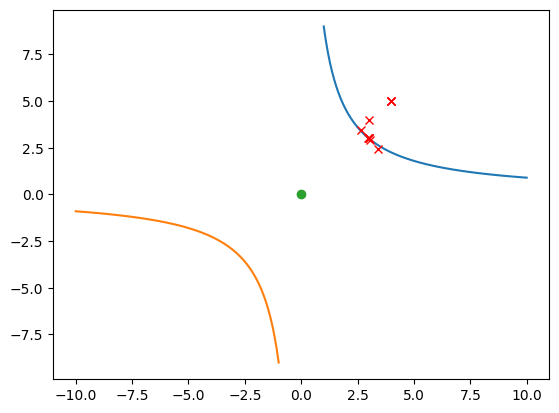

In [19]:
# Visualize the solver progress in each iteration through a callback
# Find the closest point on a curve to a desired point.

fig = plt.figure()
curve_x = np.linspace(1, 10, 100)
ax = plt.gca()
ax.plot(curve_x, 9./curve_x)
ax.plot(-curve_x, -9./curve_x)
ax.plot(0, 0, 'o')
x_init = [4., 5.]
ax.plot(x_init[0], x_init[1], 'x', color='red')

def update(x):
    ax.plot(x[0], x[1], 'x', color='red')
    
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] * x[1] == 9)
prog.AddCost(x[0]**2 + x[1]**2)
prog.AddVisualizationCallback(update, x)
result = Solve(prog, x_init)